#### Script to randomly create two dataset

In [86]:
#import the library
import pandas as pd
from sklearn.model_selection import train_test_split

#import the dataset
df = pd.read_csv('data/water_potability.csv')

#split the data into train and test set
train,test = train_test_split(df, test_size=0.30, random_state=0)

#save the data
train.to_csv('data/water_potability_v1.csv',index=False)

Above code will divide the dataset in 70%-30% in train set and test set respectively. After that it will store the train set in new CSV file to get the another version of dataset.

## DVC

Clone the mentioned Git Repository: https://github.com/krishna-bhavsar/dvc.git

#### Steps that I followed to push the data on cloud using DVC

* initialise the DVC `dvc init`
* Add the data in dvc `dvc add data/water_potability.csv`
* It will create the .dvc version of the data.
* After that, add the data on remote storage 
`dvc remote add --default myremote \
gdrive://0AIac4JZqHhKmUk9PDA/dvcstore`
* I have uploaded my dataset on google drive using above command.
* Perform operation that add the dvc storage on git as well using below command:
`git add .dvc/config`
* Next step is to store the data on dvc using `dvc push`
* Finally, Commit and push the changes on Git repository.
`git commit -m "Configure remote storage"`
`git push`

Before executing this notebook, clone git repository and first perform the below command to fetch the dataset from dvc.
* `dvc pull`

## Train the model using two different version of dataset

In [87]:
# import the libraries
import pandas as pd
import numpy as np
import io 
import dvc.api
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import (GridSearchCV, KFold, train_test_split, cross_val_score)

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline

import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

#### Data Preprocessing

In [88]:
def data_preprocessing(df):
    
    #fill the missing values with median of the attribute
    df['ph'].fillna(value=df['ph'].median(),inplace=True)
    df['Sulfate'].fillna(value=df['Sulfate'].median(),inplace=True)
    df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median(),inplace=True)
    
    print('Checking to see any more missing data \n')
    print(df.isnull().sum())

#### Feature Engineering

In [89]:
def corelation(df):
    
    #plot the heatmap to check the co-relation between the parameters
    plt.figure(figsize=(13,8))
    sns.heatmap(df.corr(),annot=True,cmap='terrain')
    plt.show()

#### Model Pipeline

In [90]:
def ml_pipeline(X_train, X_test, Y_train, Y_test):
    
    with mlflow.start_run():
        
        pipe_rf = Pipeline([('scaler', StandardScaler()), 
                    ('smote',SMOTE()),
                    ('RandomForest', RandomForestClassifier())])
        
        pipe_rf.fit(X_train, Y_train)
        
        #choose the classifier based on above comparision
        train_accuracy=pipe_rf.score(X_train, Y_train)
        test_accuracy=pipe_rf.score(X_test, Y_test)

        prediction = pipe_rf.predict(X_test)
        print('Score: ',pipe_rf.score(X_test, Y_test))
        
        accuracy = accuracy_score(Y_test,prediction)*100
        f1 = f1_score(Y_test,prediction,average='weighted')

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('n_estimators',50)
        mlflow.log_param('max_depth',2)
        mlflow.log_param('min_samples_leaf',1)
        mlflow.log_param('bootstrap',True)

        mlflow.log_metric("Train Accuracy", train_accuracy)
        mlflow.log_metric("Test Accuracy", test_accuracy)
        mlflow.log_metric("f1_score",f1)
        mlflow.log_metric("accuracy", accuracy)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.sklearn.log_model(pipe_rf, "model")
        
        return prediction

#### Model Evaluation

In [91]:
def ml_evaluation(Y_test,prediction):
    
    #Evaluation metric
    print(f"Accuracy Score = {accuracy_score(Y_test,prediction)*100}")
    print(f"Confusion Matrix =\n {confusion_matrix(Y_test,prediction)}")
    print(f"Classification Report =\n {classification_report(Y_test,prediction)}")

    sns.heatmap(confusion_matrix(Y_test, prediction), annot=True, fmt='d')
    plt.show()

#### Traing model for dataset version:1.0

In [92]:
#import the dataset using DVC python API
data = dvc.api.read('data/water_potability_v1.csv',
               repo='https://github.com/krishna-bhavsar/dvc.git')

#convert the dataset into panda dataframe
df = pd.read_csv(io.StringIO(data), sep=",")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.036752,215.997117,35971.02511,10.030508,330.858926,558.108549,14.337804,81.769775,2.934137,0
1,9.130796,200.032348,28273.60324,7.497526,333.073546,453.873571,12.860514,64.178494,3.025707,0
2,7.277144,194.880861,18270.10506,6.121931,344.879754,402.664582,15.459752,76.987232,4.931354,0
3,5.499489,230.308775,13902.96865,9.619575,352.084333,442.167006,14.740787,66.622485,5.846827,0
4,7.036752,214.737831,12666.00532,7.092691,302.491768,319.423051,15.433834,92.693936,5.005879,0


In [93]:
#print the data shape
df.shape

(2293, 10)

In [94]:
#statistics of dataset
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,7.075263,196.766104,21888.972752,7.129040,333.669851,425.608813,14.307714,66.556166,3.977328,0.394679
std,1.458588,32.591415,8736.321466,1.591804,36.478136,81.360464,3.333094,15.861530,0.769069,0.488888
min,0.000000,73.492234,320.942611,0.530351,129.000000,181.483754,2.200000,8.577013,1.450000,0.000000
25%,6.284248,177.055890,15456.220090,6.116863,316.956934,364.794883,12.049131,57.150958,3.469561,0.000000
50%,7.036752,197.049965,20922.154460,7.132154,333.073546,421.220228,14.243374,66.622485,3.961731,0.000000
75%,7.830976,217.219746,27179.404820,8.090494,351.064458,480.848064,16.584571,77.003121,4.497629,1.000000
max,14.000000,323.124000,56867.859240,13.043806,481.030642,753.342620,28.300000,116.161622,6.739000,1.000000


In [95]:
#dataset preprocessing
data_preprocessing(df)

Checking to see any more missing data 

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


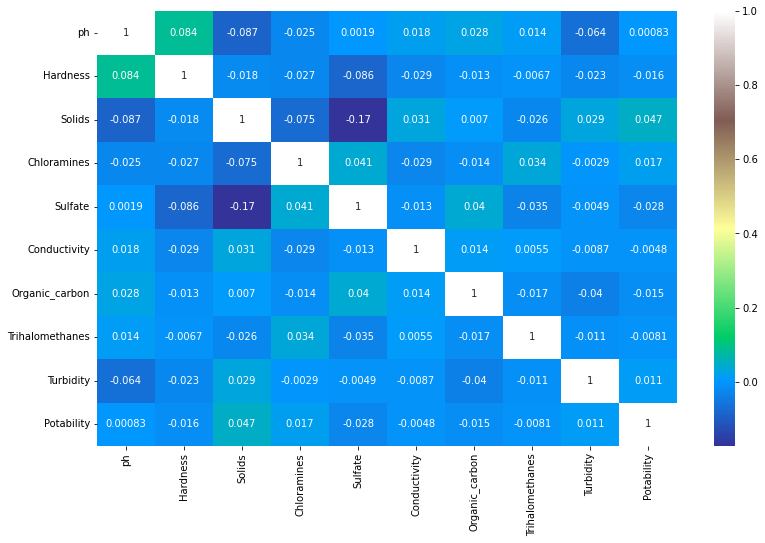

In [96]:
#finding corelation between parameters
corelation(df)

In [97]:
##################### Preparing the Data for Modelling ######################

X = df.drop('Potability', axis = 1).copy()
Y = df['Potability'].copy()

#######################split the dataset for classifier######################
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.2, random_state=101,shuffle=True)

In [98]:
#create model pipeline and fit the model
prediction = ml_pipeline(X_train, X_test, Y_train, Y_test)

Score:  0.6535947712418301


Accuracy Score = 65.359477124183
Confusion Matrix =
 [[211  80]
 [ 79  89]]
Classification Report =
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       291
           1       0.53      0.53      0.53       168

    accuracy                           0.65       459
   macro avg       0.63      0.63      0.63       459
weighted avg       0.65      0.65      0.65       459



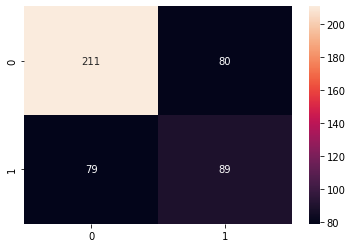

In [99]:
#model evluation
ml_evaluation(Y_test,prediction)

#### Traing model for dataset version:2.0

In [100]:
#import the dataset using DVC python API
data = dvc.api.read('data/water_potability.csv',
               repo='https://github.com/krishna-bhavsar/dvc.git')

#convert the dataset into panda dataframe
df1 = pd.read_csv(io.StringIO(data), sep=",")
df1.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [101]:
#print the data shape
df1.shape

(3276, 10)

In [102]:
#statistics of dataset
df1.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [103]:
#dataset preprocessing
data_preprocessing(df1)

Checking to see any more missing data 

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


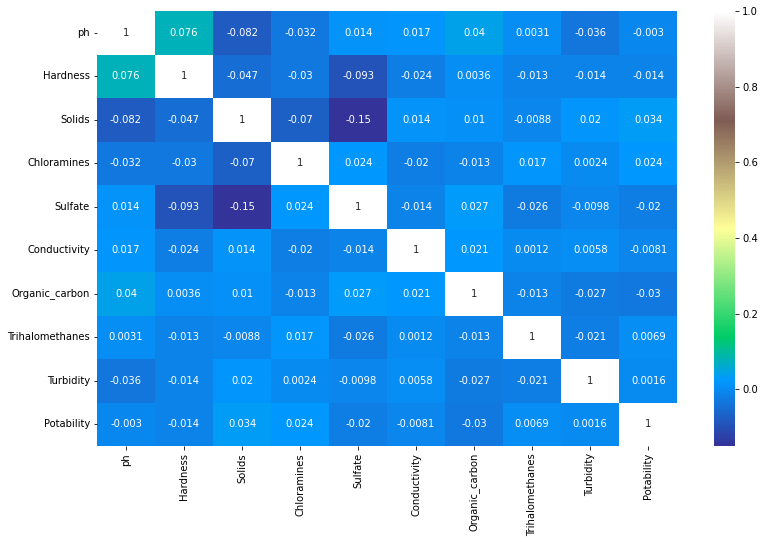

In [104]:
#finding corelation between parameters
corelation(df1)

In [105]:
##################### Preparing the Data for Modelling ######################

X = df1.drop('Potability', axis = 1).copy()
Y = df1['Potability'].copy()

#######################split the dataset for classifier######################
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.2, random_state=101,shuffle=True)

In [106]:
#create model pipeline and fit the model
prediction = ml_pipeline(X_train, X_test, Y_train, Y_test)

Score:  0.6570121951219512


Accuracy Score = 65.70121951219512
Confusion Matrix =
 [[300 102]
 [123 131]]
Classification Report =
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       402
           1       0.56      0.52      0.54       254

    accuracy                           0.66       656
   macro avg       0.64      0.63      0.63       656
weighted avg       0.65      0.66      0.65       656



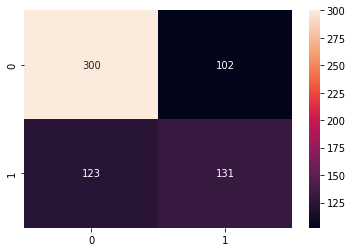

In [107]:
#model evluation
ml_evaluation(Y_test,prediction)

#### Comparison of two models trained on different dataset

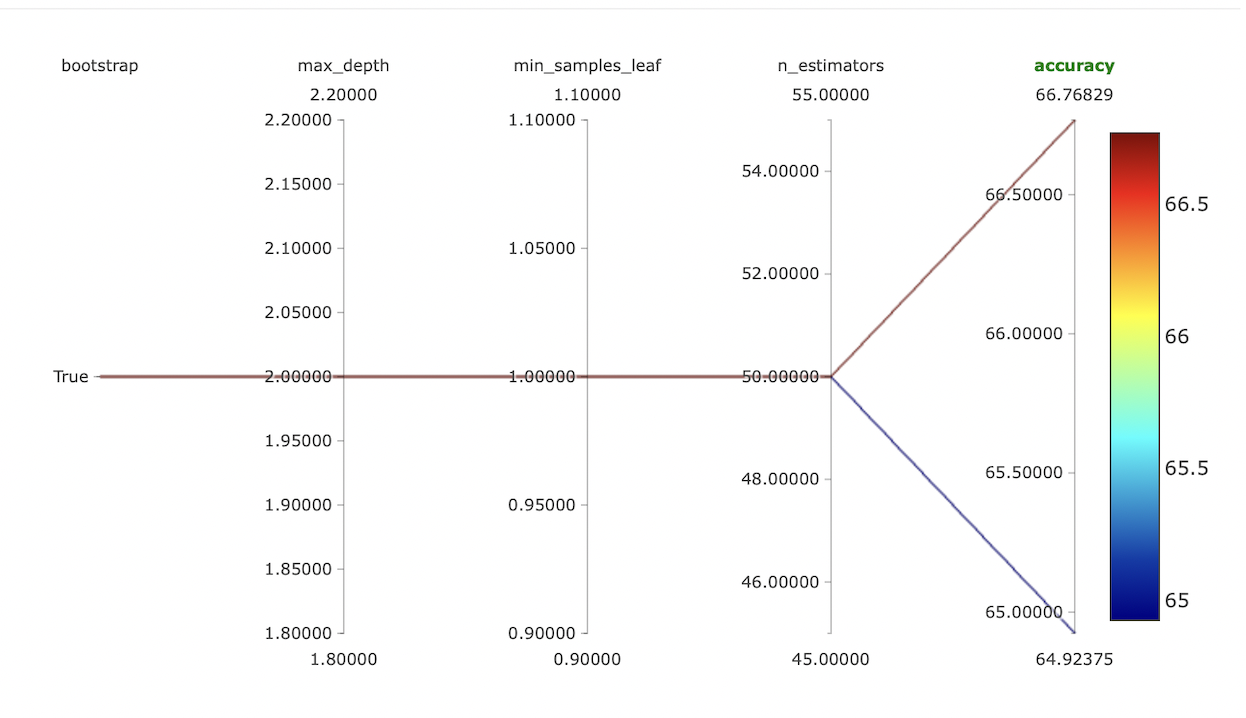

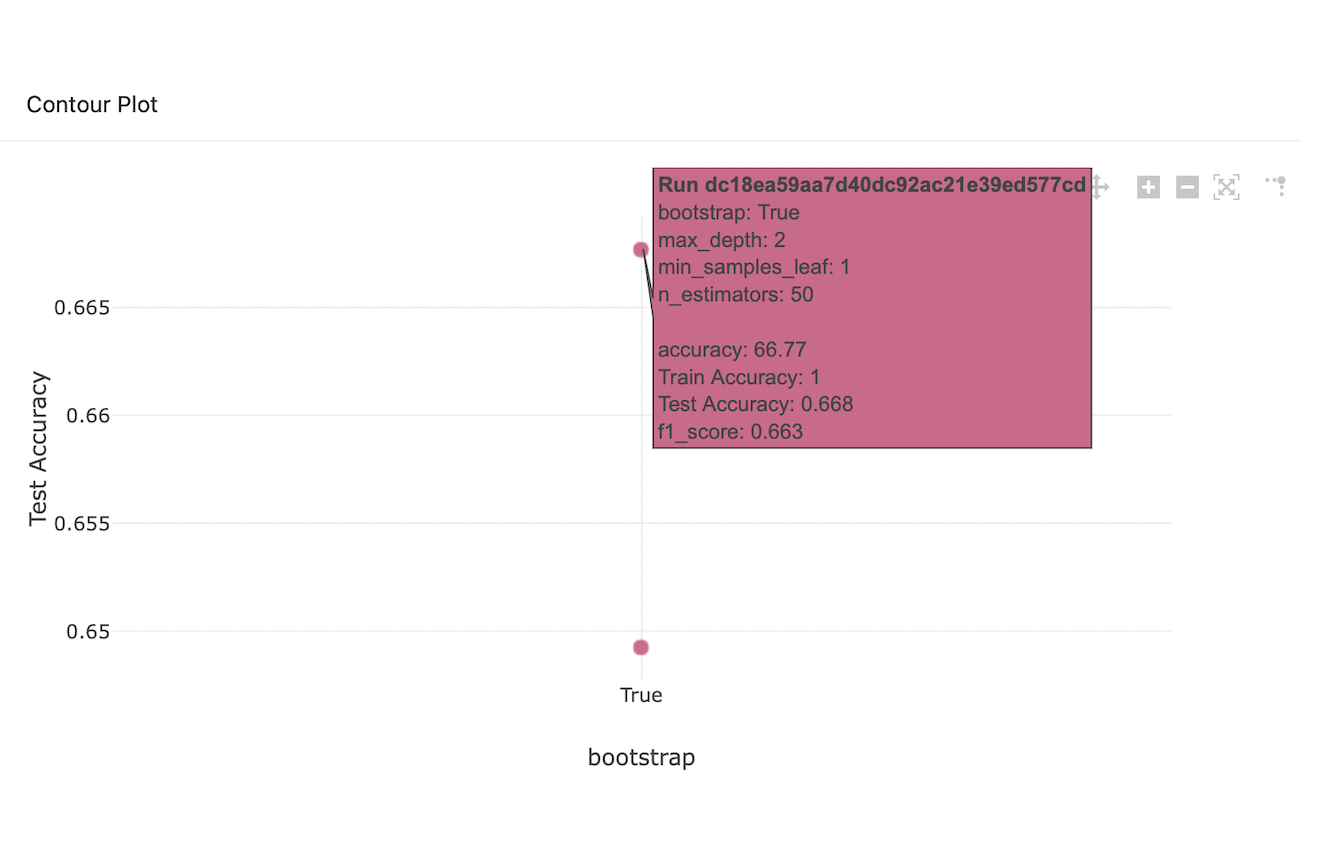

As per above results, accuracy of model1 is lower compare to model2 as dataset2 has more samples than dataset1.Therefore, the version2 of dataset is better.

In [52]:
!mlflow ui

[2022-06-11 16:52:43 -0400] [49300] [INFO] Starting gunicorn 20.1.0
[2022-06-11 16:52:43 -0400] [49300] [INFO] Listening at: http://127.0.0.1:5000 (49300)
[2022-06-11 16:52:43 -0400] [49300] [INFO] Using worker: sync
[2022-06-11 16:52:43 -0400] [49301] [INFO] Booting worker with pid: 49301
^C
[2022-06-11 16:53:57 -0400] [49300] [INFO] Handling signal: int
[2022-06-11 16:53:57 -0400] [49301] [INFO] Worker exiting (pid: 49301)
